
# Phishing Website Detection

This notebook explores the process of building a machine learning model to detect phishing websites. 


In [1]:

# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn utilities for feature selection, model training, and evaluation
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as cuRfc

# Gradient boosting framework
import lightgbm as lgb


In [2]:
# Data Loading and Initial Exploration

# Load the data
data = pd.read_csv('Phishing_Legitimate_full.csv')

# Checking for missing values in the dataset
print(data.isnull().sum())


id                                    0
NumDots                               0
SubdomainLevel                        0
PathLevel                             0
UrlLength                             0
NumDash                               0
NumDashInHostname                     0
AtSymbol                              0
TildeSymbol                           0
NumUnderscore                         0
NumPercent                            0
NumQueryComponents                    0
NumAmpersand                          0
NumHash                               0
NumNumericChars                       0
NoHttps                               0
RandomString                          0
IpAddress                             0
DomainInSubdomains                    0
DomainInPaths                         0
HttpsInHostname                       0
HostnameLength                        0
PathLength                            0
QueryLength                           0
DoubleSlashInPath                     0


In [3]:
# id: A unique identifier for each entry.
# NumDots: Number of dots in the URL.
# SubdomainLevel: Number of subdomains in the URL.
# PathLevel: Number of paths in the URL.
# UrlLength: Length of the URL.
# NumDash: Number of dashes in the URL.
# NumDashInHostname: Number of dashes in the hostname.
# AtSymbol: Presence of '@' symbol in the URL.
# TildeSymbol: Presence of tilde symbol in the URL.
# NumUnderscore: Number of underscores in the URL.
# NumPercent: Number of percent symbols in the URL.
# NumQueryComponents: Number of query components in the URL.
# NumAmpersand: Number of ampersands in the URL.
# NumHash: Number of hash symbols in the URL.
# NumNumericChars: Number of numeric characters in the URL.
# NoHttps: Absence of 'https' in the URL.
# RandomString: Presence of a random string in the URL.
# IpAddress: Presence of an IP address in the URL.
# DomainInSubdomains: Presence of the domain name in the subdomains.
# DomainInPaths: Presence of the domain name in the URL path.
# HttpsInHostname: Presence of 'https' in the hostname.
# HostnameLength: Length of the hostname.
# PathLength: Length of the URL path.
# QueryLength: Length of the URL query.
# DoubleSlashInPath: Presence of double slashes in the URL path.
# NumSensitiveWords: Number of sensitive words in the URL.
# EmbeddedBrandName: Presence of a brand name embedded in the URL.
# PctExtHyperlinks: Percentage of external hyperlinks in the webpage.
# PctExtResourceUrls: Percentage of external resource URLs in the webpage.
# ExtFavicon: External favicon used in the webpage.
# InsecureForms: Presence of insecure forms on the webpage.
# RelativeFormAction: Presence of relative form actions on the webpage.
# ExtFormAction: External form action used on the webpage.
# AbnormalFormAction: Abnormal form actions found on the webpage.
# PctNullSelfRedirectHyperlinks: Percentage of self-redirecting hyperlinks with null content.
# FrequentDomainNameMismatch: Frequency of domain name mismatches.
# FakeLinkInStatusBar: Presence of fake links in the browser's status bar.
# RightClickDisabled: Right-click functionality disabled on the webpage.
# PopUpWindow: Pop-up windows used on the webpage.
# SubmitInfoToEmail: Form submissions directed to an email address.
# IframeOrFrame: Presence of iframes or frames on the webpage.
# MissingTitle: Missing title tag on the webpage.
# ImagesOnlyInForm: Only images used in forms on the webpage.
# SubdomainLevelRT: Runtime analysis of subdomain levels.
# UrlLengthRT: Runtime analysis of URL length.
# PctExtResourceUrlsRT: Runtime analysis of percentage of external resource URLs.
# AbnormalExtFormActionR: Abnormal external form actions found during runtime.
# ExtMetaScriptLinkRT: External meta script links used during runtime.
# PctExtNullSelfRedirectHyperlinksRT: Runtime percentage of self-redirecting hyperlinks with null content.

In [4]:
# Renaming the 'CLASS_LABEL' column to 'labels' for better readability
data.rename(columns={'CLASS_LABEL': 'labels'}, inplace=True)

In [5]:
# Exploratory Data Analysis (EDA)

# Setting display options for pandas and plotting
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12,6)

In [6]:
# Displaying statistical summary of the data
data.describe()

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,NumQueryComponents,NumAmpersand,NumHash,NumNumericChars,NoHttps,RandomString,IpAddress,DomainInSubdomains,DomainInPaths,HttpsInHostname,HostnameLength,PathLength,QueryLength,DoubleSlashInPath,NumSensitiveWords,EmbeddedBrandName,PctExtHyperlinks,PctExtResourceUrls,ExtFavicon,InsecureForms,RelativeFormAction,ExtFormAction,AbnormalFormAction,PctNullSelfRedirectHyperlinks,FrequentDomainNameMismatch,FakeLinkInStatusBar,RightClickDisabled,PopUpWindow,SubmitInfoToEmail,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,labels
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.0,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,2.445100,0.586800,3.300300,70.264100,1.818000,0.138900,0.000300,0.013100,0.32320,0.073800,0.458600,0.277200,0.002300,5.810300,0.988800,0.52520,0.017200,0.022200,0.428900,0.0,18.82430,35.564900,8.606500,0.000900,0.109300,0.057100,0.241334,0.392932,0.167200,0.844000,0.248700,0.1018,0.057600,0.136136,0.215300,0.005500,0.014000,0.004900,0.128800,0.339600,0.03220,0.030400,0.956600,0.020200,0.353300,0.793200,0.173400,0.314100,0.500000
std,2886.89568,1.346836,0.751214,1.863241,33.369877,3.106258,0.545744,0.017319,0.113709,1.11466,0.622248,1.344793,1.117356,0.047906,9.617877,0.105241,0.49939,0.130023,0.147341,0.494944,0.0,8.11654,24.588502,24.313053,0.029988,0.368737,0.232045,0.342370,0.387292,0.373173,0.362873,0.432281,0.3024,0.232997,0.312413,0.411051,0.073961,0.117496,0.069832,0.334995,0.473597,0.17654,0.171694,0.248037,0.820036,0.888908,0.521019,0.755771,0.897843,0.500025
min,1.00000,1.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,4.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2500.75000,2.000000,0.000000,2.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.0,14.00000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,1.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,-1.000000,-1.000000,1.000000,0.000000,-1.000000,0.000000
50%,5000.50000,2.000000,1.000000,3.000000,62.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.0,18.00000,30.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.247511,0.000000,1.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.500000
75%,7500.25000,3.000000,1.000000,4.000000,84.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000,1.00000,0.000000,0.000000,1.000000,0.0,22.00000,48.000000,0.000000,0.000000,0.000000,0.000000,0.315874,0.785714,0.000000,1.000000,0.000000,0.0000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000

In [7]:
# Balance/Imbalanced Data
# The data is balanced for non-phising and phising label

<AxesSubplot:>

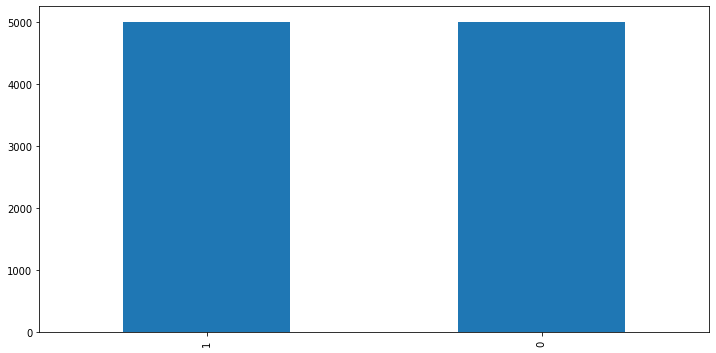

In [8]:
# Checking the balance of the target variable
data['labels'].value_counts().plot(kind='bar')

In [9]:
# Spearman Correlation Analysis

# This section checks the correlation between features and the target variable using Spearman correlation
# Spearman correlation is used to identify non-linear relationships between variables

# By looking the spearman correlation, we can find which features are linearly correlated in terms of predicting if a site is phising or not

def corr_heatmap(data, idx_s, idx_e):
    y = data['labels']
    temp = data.iloc[:, idx_s:idx_e]
    if 'id' in temp.columns:
        del temp['id']
    temp['labels'] = y
    sns.heatmap(temp.corr(), annot=True, fmt='.2f')
    plt.show()

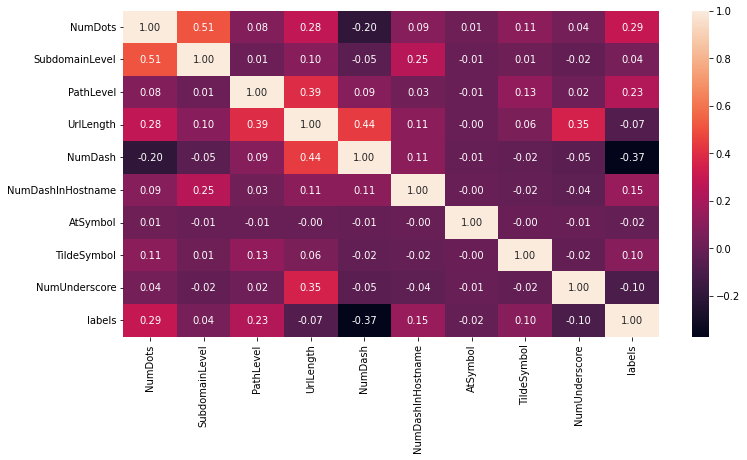

In [10]:
# Heatmap

corr_heatmap(data, 0, 10)

# By looking at the first 10 columns against labels, we can concluded that non of the features have strong correlation with the labels, however, NumDash has some significant negative effect towards the labels, which could mean if there is less number of dash then it is more likely to be phising site


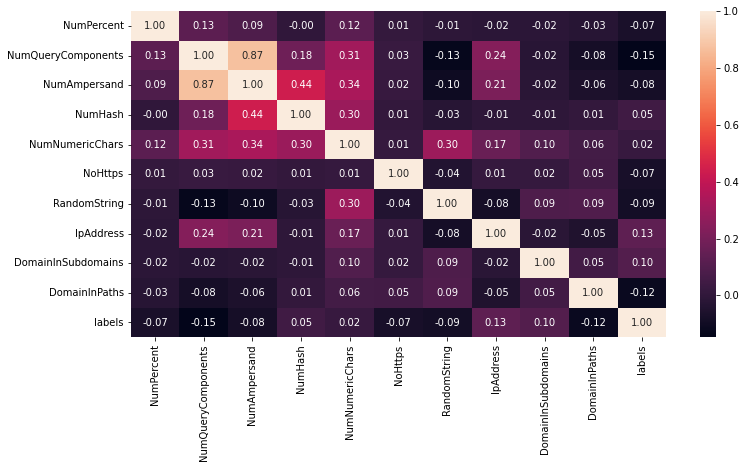

In [11]:
corr_heatmap(data, 10, 20)

# There are no strong or even medium level strength correlation features with labels




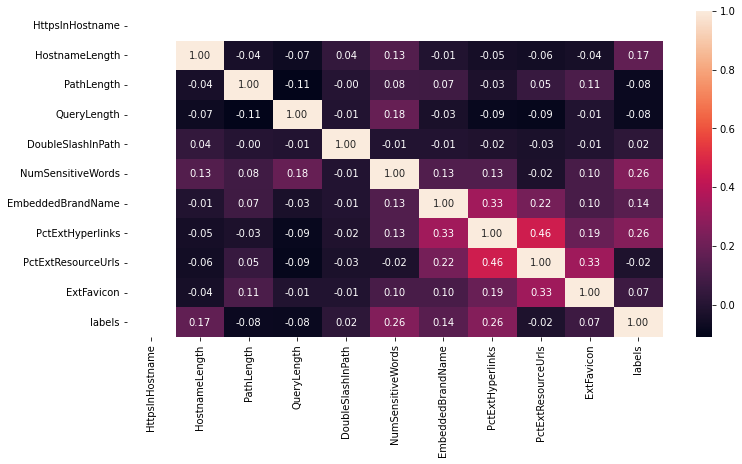

In [12]:
corr_heatmap(data, 20, 30)

# Still no strong correlation feature


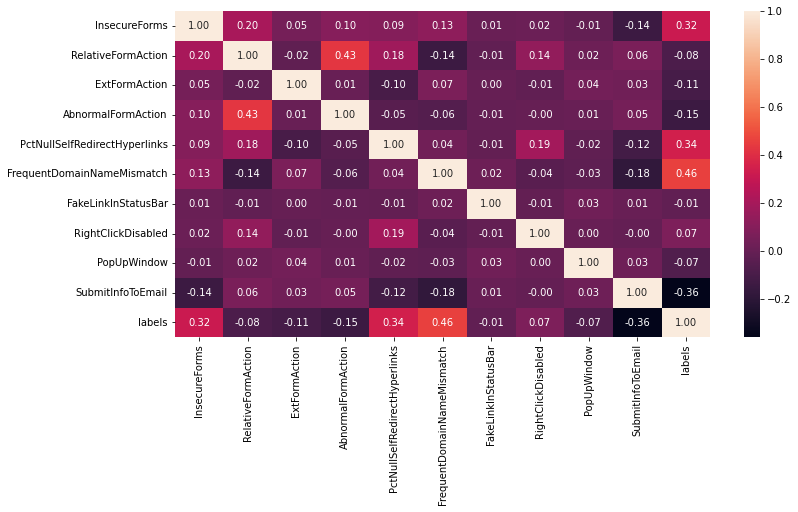

In [13]:
corr_heatmap(data, 30, 40)

# Well here we have a few features that are linearly correlated to our dep variable

# InsecureForms shows that as the value is higher so the probability of being a phising site
# PctNullSelfRedirectHyperlinks shows the same positive correlation as InsecureForms
# FequentDomainNameMismatch shows that it has medium linear correlation in positive direction
# SubmitInfoToEmail seems to indicate that sites that ask users to submit their details to emails seems to be more high probability for phising





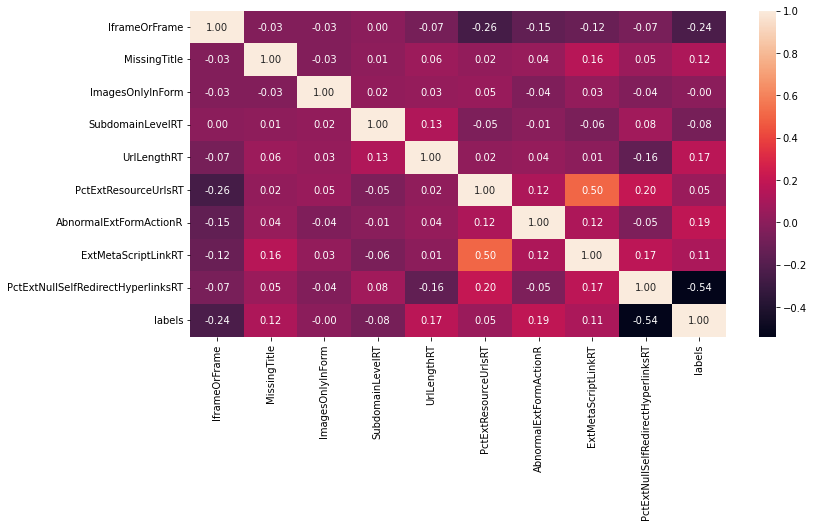

In [14]:
corr_heatmap(data, 40, 50)

# The only column in this group that has some correlation with labels is PctExtNullSelfRedirectHyperlinksRT and it has negative effect towards labels which could mean that when the number of percent of null self redirect hyperlinks occur hence the probabiliy of phising increases

In [15]:
# Mutual Info
# We will use mutual info classifier to find non linear and linear correlation betweem the features and labels

In [16]:
# Feature Importance using Mutual Information

# Using mutual information to determine both linear and non-linear correlations between features and the target
X = data.drop(['id', 'labels'], axis=1)
y = data['labels']

# Identifying discrete features for mutual info calculation
discrete_features = X.dtypes == int

# Calculating mutual information scores for each feature
mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores


PctExtHyperlinks                      0.465175
PctExtResourceUrls                    0.293480
PctNullSelfRedirectHyperlinks         0.234313
PctExtNullSelfRedirectHyperlinksRT    0.216140
FrequentDomainNameMismatch            0.129210
NumNumericChars                       0.127767
NumDash                               0.119388
ExtMetaScriptLinkRT                   0.115503
SubmitInfoToEmail                     0.084421
NumDots                               0.063479
InsecureForms                         0.057361
PathLength                            0.056423
PathLevel                             0.052555
QueryLength                           0.048821
UrlLength                             0.041050
NumSensitiveWords                     0.038460
PctExtResourceUrlsRT                  0.031479
NumQueryComponents                    0.031119
NumAmpersand                          0.023112
IframeOrFrame                         0.021693
HostnameLength                        0.018681
MissingTitle 

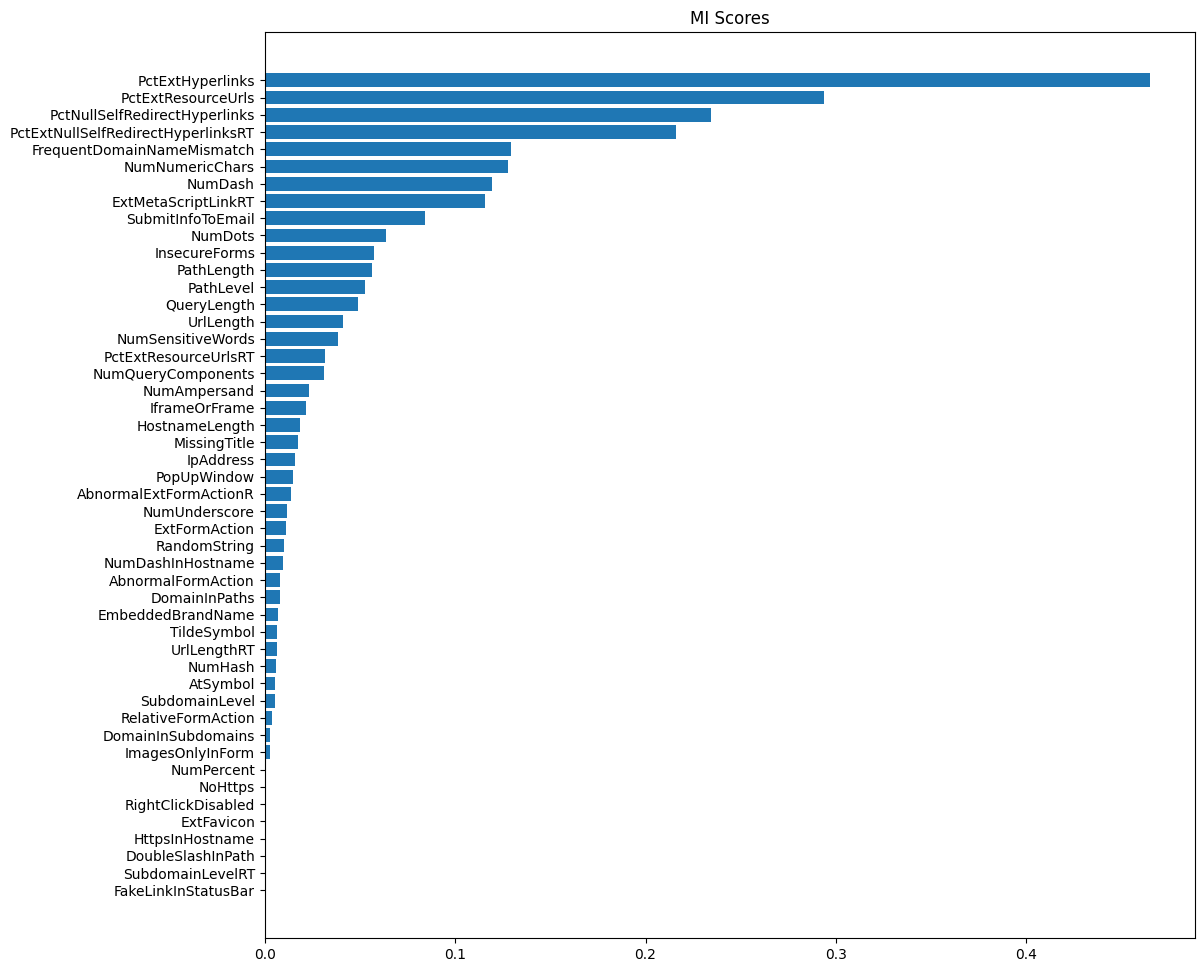

In [17]:
# Visualizing Mutual Information Scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("MI Scores")
    
# Plotting the MI scores
plt.figure(dpi=100, figsize=(12,12))
plot_mi_scores(mi_scores)

Prediction

In [18]:
# We will first use logistic regression as for baseline, then try to beat the baseline using random forest classifer

# Our evaluation metrics will be accuracy, precision, recall and f1 score

# Below we import all the required modules

In [19]:
# Train logistic models
# This method is to perform a repetative training process using logistic regression model, the purpose for this is to find the optimal number of features that can be used to find the best fitted model without adjusting much of the hyperparameters, hence the idea here is to go with Data-Centric training, basically the method takes number of top N features to be used for training the model and all the evaluation metrics are returned for evaluation purpose

In [20]:
# Model Training using Logistic Regression

# The goal is to use logistic regression as a baseline model. 
# The model will be trained using the top N features determined by mutual information scores.
# Evaluation metrics include accuracy, precision, recall, and F1 score.

# Train logistic regression model
def train_logistic(data, top_n):
    # Selecting the top N features
    top_n_features = mi_scores.sort_values(ascending=False).head(top_n).index.tolist()
    X = data[top_n_features]
    y = data['labels']
    
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    # Training the logistic regression model
    lr = LogisticRegression(max_iter=10000)
    lr.fit(X_train, y_train)

    # Predicting on the test set
    y_pred = lr.predict(X_test)
    
    # Calculating evaluation metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    return precision, recall, f1, accuracy

In [21]:
# Iterating over different numbers of top features and collecting performance metrics for each iteration
arr = []
for i in range(20,51,1):
    precision, recall, f1, accuracy = train_logistic(data, i)
    print("Performance for Logistic Model with Top {} features is precision : {}, recall : {}, f1 score : {}, accuracy : {}".format(i, precision, recall, f1, accuracy))
    arr.append([i, precision, recall, f1, accuracy])

Performance for Logistic Model with Top 20 features is precision : 0.9097222222222222, recall : 0.9532224532224532, f1 score : 0.9309644670050761, accuracy : 0.932
Performance for Logistic Model with Top 21 features is precision : 0.927710843373494, recall : 0.9333333333333333, f1 score : 0.9305135951661632, accuracy : 0.931
Performance for Logistic Model with Top 22 features is precision : 0.9196865817825661, recall : 0.9324726911618669, f1 score : 0.9260355029585798, accuracy : 0.925
Performance for Logistic Model with Top 23 features is precision : 0.9071146245059288, recall : 0.9291497975708503, f1 score : 0.918, accuracy : 0.918
Performance for Logistic Model with Top 24 features is precision : 0.9253588516746412, recall : 0.9379243452958292, f1 score : 0.9315992292870905, accuracy : 0.929
Performance for Logistic Model with Top 25 features is precision : 0.9186274509803921, recall : 0.9417085427135679, f1 score : 0.9300248138957815, accuracy : 0.9295
Performance for Logistic Mode

In [22]:
# Converting the collected metrics into a dataframe for easier analysis
df = pd.DataFrame(arr, columns=['num_of_features', 'precision', 'recall', 'f1_score', 'accuracy'])

# Displaying the dataframe containing the metrics
df

,num_of_features,precision,recall,f1_score,accuracy
0,20,0.909722,0.953222,0.930964,0.9320
1,21,0.927711,0.933333,0.930514,0.9310
2,22,0.919687,0.932473,0.926036,0.9250
3,23,0.907115,0.929150,0.918000,0.9180
4,24,0.925359,0.937924,0.931599,0.9290
5,25,0.918627,0.941709,0.930025,0.9295
6,26,0.910593,0.937938,0.924063,0.9230
7,27,0.914151,0.932628,0.923297,0.9195
8,28,0.922849,0.928358,0.925595,0.9250
9,29,0.929842,0.930762,0.930302,0.9295


In [23]:
# Model Training and Evaluation Functions

def train_and_evaluate(model, X, y):
    results = []
    skf = StratifiedKFold(n_splits=5)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculating performance metrics
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        
        results.append([precision, recall, f1, accuracy, roc_auc])
        
    # Averaging the scores over all folds
    mean_scores = np.mean(results, axis=0)
    return mean_scores


In [24]:
# Model Pipeline and Hyperparameter Tuning

# Defining a pipeline for scaling the data and training with LightGBM classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('lgbm', lgb.LGBMClassifier())
])

# Parameters for RandomizedSearch
param_dist = {
    'lgbm__n_estimators': [50, 100, 200, 300],
    'lgbm__learning_rate': [0.01, 0.05, 0.1],
    'lgbm__max_depth': [-1, 10, 20, 30],
    'lgbm__num_leaves': [31, 60, 90, 120]
}

# Using RandomizedSearchCV to find the best hyperparameters based on ROC AUC score
search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=5)

# Splitting the data into training and testing sets
X = data.drop(columns=['labels'])
y = data['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting the model using the best hyperparameters
search.fit(X_train, y_train)

# Displaying the best hyperparameters found during the search
print("Best parameters found: ", search.best_params_)
# Extracting the best model from the search
best_model = search.best_estimator_

# Evaluating the performance of the best model
precision, recall, f1, accuracy, roc_auc = train_and_evaluate(best_model, X, y)
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}, Accuracy: {accuracy}, ROC-AUC: {roc_auc}")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3988, number of negative: 4012
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1805
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498500 -> initscore=-0.006000
[LightGBM] [Info] Start training from score -0.006000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [25]:
# Training using Random Forest Classifier on GPU

# It is the same method as logistic reg, the only diff is that we are now using random forest classifier for training and trying to beat the logistic baseline

# The purpose of this section is to train a Random Forest Classifier using a GPU. 
# The method aims to potentially enhance the performance and reduce the training time.
# The Random Forest model will be trained using the top N features determined by mutual information scores.
# The goal is to try and surpass the performance of the logistic regression baseline.


def train_rfc_gpu(df, top_n):
    # Selecting the top N features
    top_n_features = mi_scores.sort_values(ascending=False).head(top_n).index.tolist()
    X = df[top_n_features]
    y = df['labels']
    
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    # Training the Random Forest Classifier on GPU
    rfc = cuRfc(n_estimators=500,  
                max_depth=32, 
                max_features=1.0)
    
    rfc.fit(X_train, y_train)
    
    # Predicting on the test set
    y_pred = rfc.predict(X_test)
    
    # Calculating evaluation metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    return precision, recall, f1, accuracy, y_test, y_pred

# Iterating over different numbers of top features and collecting performance metrics for each iteration
results_rfc = []
all_y_test = []
all_y_pred = []

for i in range(20, 22, 1):
    precision, recall, f1, accuracy, y_test, y_pred = train_rfc_gpu(data, i)
    print("Performance for RFC Model on GPU with Top {} features is precision : {}, recall : {}, f1 score : {}, accuracy : {}".format(i, precision, recall, f1, accuracy))
    results_rfc.append([i, precision, recall, f1, accuracy])
    
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

rfc_results_df = pd.DataFrame(results_rfc, columns=['num_of_features', 'precision', 'recall', 'f1_score', 'accuracy'])

# Generate a single classification report using the accumulated values
print(classification_report(all_y_test, all_y_pred))


Performance for RFC Model on GPU with Top 20 features is precision : 0.9782178217821782, recall : 0.9733990147783251, f1 score : 0.9758024691358025, accuracy : 0.9755
Performance for RFC Model on GPU with Top 21 features is precision : 0.9730807577268196, recall : 0.9740518962075848, f1 score : 0.97356608478803, accuracy : 0.9735
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1983
           1       0.98      0.97      0.97      2017

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



In [26]:
# Performance
# The model is now capable of predicting at up to 98% accuracy and also precision and recall, this shows the model has high confidence in predicting phishing or non-phishing site

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


<Figure size 576x432 with 0 Axes>

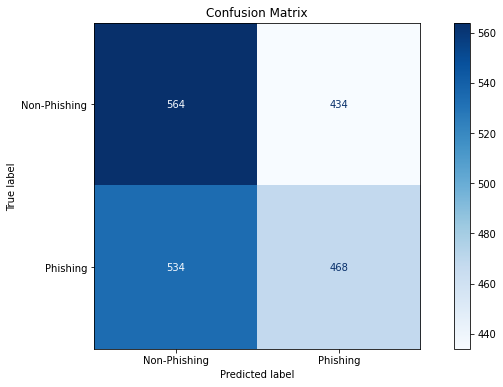

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


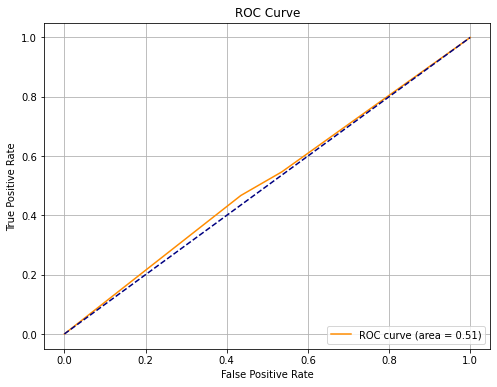

In [27]:
# Visualization: Confusion Matrix

# This function provides a way to visualize the confusion matrix, which gives insight into the true positives, 
# true negatives, false positives, and false negatives of the model's predictions.

# Plots a confusion matrix for the given true and predicted labels.
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Phishing', 'Phishing'])
    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plots the ROC curve for the given true labels and predicted probability scores.
def plot_roc_curve(y_true, y_prob, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# After training the model and obtaining predictions
# Visualize the confusion matrix
y_pred = best_model.predict(X_test)

# Visualize the confusion matrix
plot_confusion_matrix(y_test, y_pred)

# If the best model supports the predict_proba method, get the probability scores.
if hasattr(best_model, 'predict_proba'):
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Probability scores for the positive class
    plot_roc_curve(y_test, y_prob)


In [28]:
# Creating the synthetic entry based on dataset's median values
synthetic_entry = data.median(numeric_only=True).drop('labels', errors='ignore')
synthetic_entry_df = synthetic_entry.to_frame().transpose()

# Making sure the synthetic entry has the same columns as the original dataset
for col in data.columns:
    if col not in synthetic_entry_df.columns:
        synthetic_entry_df[col] = None

# Reordering columns to match the original dataset
synthetic_entry_df = synthetic_entry_df[data.columns]

# Removing the 'CLASS_LABEL' column as it's the target variable
synthetic_entry_df = synthetic_entry_df.drop('labels', axis=1)

print("Synthetic Entry Based on Dataset's Median Values:")

# Formatting synthetic_entry_df for better visualization
formatted_synthetic_entry = synthetic_entry_df.transpose()
formatted_synthetic_entry.columns = ["Value"]

formatted_synthetic_entry 


Synthetic Entry Based on Dataset's Median Values:


,Value
id,5000.500000
NumDots,2.000000
SubdomainLevel,1.000000
PathLevel,3.000000
UrlLength,62.000000
NumDash,0.000000
NumDashInHostname,0.000000
AtSymbol,0.000000
TildeSymbol,0.000000
NumUnderscore,0.000000


In [29]:
# Data Preprocessing
X = data.drop('labels', axis=1)
y = data['labels']

# Model Training using Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = cuRfc(random_state=42)
rf_classifier.fit(X_train, y_train)

# Prediction on Synthetic Entry
synthetic_prediction_rf = rf_classifier.predict(synthetic_entry_df)

# Formatting the prediction output
prediction_result = "non-phishing" if synthetic_prediction_rf[0] == 0 else "phishing"

prediction_result

'non-phishing'